<a href="https://colab.research.google.com/github/Yanina-Kutovaya/ccfd/blob/main/notebooks/EDA_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Credit Card Fraud Detection
Anonymized credit card transactions labeled as fraudulent or genuine

data: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
#!pip install --pre pycaret --quiet
#!pip install mlflow --quiet
#!pip uninstall matplotlib
#!pip install matplotlib==3.1.3
#!pip install pycaret[analysis]
#!pip install interpret-community

In [2]:
import mlflow
import pandas as pd
from pandas.core.aggregation import normalize_keyword_aggregation
from pycaret.classification import *
from sklearn.model_selection import StratifiedShuffleSplit

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_URL = 'https://storage.yandexcloud.net/ccfd-input-data/archive.zip'
data = pd.read_csv(DATA_URL)

## 1. Dataset overview

In [5]:
print(f'data.shape = {data.shape}\n')
data.head(2)

data.shape = (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [6]:
TARGET = 'Class'
cols = data.columns.drop(TARGET)

In [7]:
data[TARGET].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
data[TARGET].value_counts(normalize_keyword_aggregation)

0    0.998273
1    0.001727
Name: Class, dtype: float64

* No Frauds are 99.83 % of the dataset
* Frauds are 0.17 % of the dataset

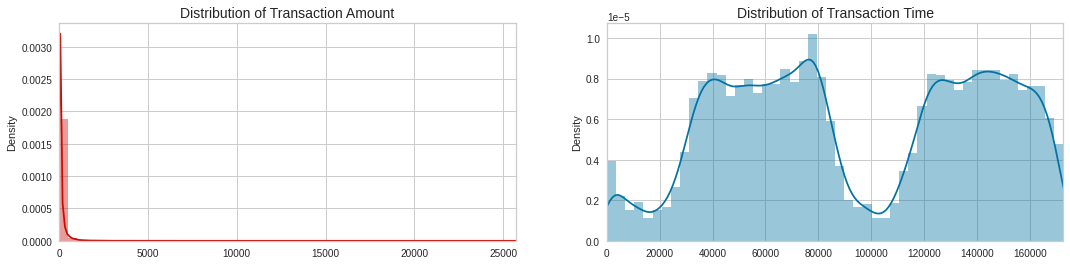

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [10]:
data.loc[:, 'V1':'Amount'].describe().T

,count,mean,std,min,25%,50%,75%,max
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995
V10,284807.0,2.239053e-15,1.088850,-24.588262,-0.535426,-0.092917,0.453923,23.745136


## 2. Train test split

In [11]:
t = 150000

train = data[data['Time'] < t]
test = data[data['Time'] >= t]
len(train) / len(data)

0.8398424196034507

In [12]:
train[TARGET].value_counts(normalize_keyword_aggregation)

0    0.998181
1    0.001819
Name: Class, dtype: float64

## 3. Train dataset undersampling

In [13]:
a = set(train[train[TARGET] == 0].sample(frac=0.05, random_state=15).index)
b = set(train[train[TARGET] == 1].index)
df = train.loc[a | b, :]

print(f'df.shape = {df.shape}\n')
df.head(2)

df.shape = (12373, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32770,36958.0,1.036122,-0.771819,0.020665,-0.460113,-0.348211,0.772958,-0.724683,0.388630,-0.597540,...,0.099284,0.268661,0.097517,-0.720561,0.074032,-0.198719,0.076757,0.038300,85.69,0
131075,79494.0,1.145350,-0.553647,0.956380,-0.828257,-1.201592,-0.182917,-0.853367,0.326851,1.776966,...,0.062656,0.352606,0.024985,0.206025,0.318095,-0.681784,0.096524,0.020463,1.00,0


In [14]:
df[TARGET].value_counts(normalize_keyword_aggregation)

0    0.964843
1    0.035157
Name: Class, dtype: float64

## 4. Setting up Environment in PyCaret

In [15]:
exp_clf = setup(
    data = df, target = TARGET, session_id = 1,
    ignore_features = [
        'Time', 'V8','V13', 'V15', 'V20', 'V22', 'V23', 'V24', 'V25', '26', 'V27', 'V28'
    ],
    normalize = True, normalize_method = 'robust',
    transformation = True,
    bin_numeric_features = ['Amount'],
    log_experiment = 'mlflow',    
    experiment_name='ccfd1'
)

,Description,Value
0,Session id,1
1,Target,Class
2,Target type,Binary
3,Original data shape,"(12373, 20)"
4,Transformed data shape,"(12373, 20)"
5,Transformed train set shape,"(8661, 20)"
6,Transformed test set shape,"(3712, 20)"
7,Ignore features,12
8,Numeric features,19
9,Preprocess,True


## 5. Comparing All Models

In [16]:
top3 = compare_models(n_select = 3, sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9949,0.9750,0.8623,0.9924,0.9216,0.9190,0.9220,0.5800
lightgbm,Light Gradient Boosting Machine,0.9945,0.9842,0.8589,0.9808,0.9147,0.9118,0.9146,0.4860
rf,Random Forest Classifier,0.9943,0.9644,0.8557,0.9815,0.9128,0.9099,0.9130,2.4690
lr,Logistic Regression,0.9940,0.9772,0.8425,0.9851,0.9066,0.9035,0.9073,0.4810
knn,K Neighbors Classifier,0.9932,0.9464,0.8361,0.9673,0.8943,0.8909,0.8948,0.4520
lda,Linear Discriminant Analysis,0.9933,0.9708,0.8162,0.9915,0.8935,0.8901,0.8956,0.0960
gbc,Gradient Boosting Classifier,0.9925,0.9730,0.8655,0.9186,0.8895,0.8857,0.8870,4.2030
ada,Ada Boost Classifier,0.9925,0.9753,0.8495,0.9343,0.8875,0.8836,0.8860,0.9570
svm,SVM - Linear Kernel,0.9923,0.0000,0.8326,0.9411,0.8820,0.8781,0.8806,0.0990
dt,Decision Tree Classifier,0.9882,0.9244,0.8557,0.8263,0.8371,0.8310,0.8331,0.2120


Processing:   0%|          | 0/63 [00:00<?, ?it/s]

In [17]:
pprint(top3)

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1, verbose=0, warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, cl

## 6. Optimizing

### 6.1 Create Model

In [18]:
et = create_model('et', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9937,0.9870,0.8197,1.0000,0.9009,0.8977,0.9024
1,0.9965,0.9831,0.9000,1.0000,0.9474,0.9456,0.9470
2,0.9936,0.9527,0.8361,0.9808,0.9027,0.8994,0.9025
3,0.9965,0.9849,0.9180,0.9825,0.9492,0.9474,0.9479
4,0.9931,0.9640,0.8033,1.0000,0.8909,0.8874,0.8931
Mean,0.9947,0.9744,0.8554,0.9926,0.9182,0.9155,0.9186
Std,0.0015,0.0136,0.0453,0.0090,0.0249,0.0256,0.0238


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### 6.2 Tune a Model

In [19]:
tuned_et = tune_model(et, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9919,0.9659,0.7742,1.0000,0.8727,0.8686,0.8762
1,0.9942,0.9916,0.8667,0.9630,0.9123,0.9093,0.9107
2,0.9988,0.9923,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.9599,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9896,0.9648,0.7333,0.9565,0.8302,0.8249,0.8327
5,0.9942,0.9684,0.8667,0.9630,0.9123,0.9093,0.9107
6,0.9942,0.9922,0.9000,0.9310,0.9153,0.9123,0.9124
7,0.9965,0.9766,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9931,0.9568,0.8065,1.0000,0.8929,0.8893,0.8948


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [20]:
plot_model(top3[0], plot = 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


### 6.3 Ensemble a Model

#### 6.3.1 Bagging

In [21]:
bagged_et = ensemble_model(top3[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9919,0.9734,0.7742,1.0000,0.8727,0.8686,0.8762
1,0.9954,0.9928,0.8667,1.0000,0.9286,0.9262,0.9287
2,0.9988,0.9923,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.9770,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9908,0.9398,0.7667,0.9583,0.8519,0.8471,0.8528
5,0.9965,0.9741,0.9000,1.0000,0.9474,0.9456,0.9470
6,0.9965,0.9971,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.9606,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9931,0.9902,0.8065,1.0000,0.8929,0.8893,0.8948


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Check the parameters of bagged_rf

In [22]:
print(bagged_et)

BaggingClassifier(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                      ccp_alpha=0.0,
                                                      class_weight=None,
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                     

#### 6.3.2 Boosting

In [23]:
boosted_et = ensemble_model(top3[0], method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9919,0.9801,0.7742,1.0000,0.8727,0.8686,0.8762
1,0.9954,0.9942,0.8667,1.0000,0.9286,0.9262,0.9287
2,0.9988,0.9934,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.9720,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9908,0.9120,0.7667,0.9583,0.8519,0.8471,0.8528
5,0.9965,0.9883,0.9000,1.0000,0.9474,0.9456,0.9470
6,0.9965,0.9985,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.9565,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9931,0.9837,0.8065,1.0000,0.8929,0.8893,0.8948


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

#### 6.3.3 Blending

Blend individual models

In [24]:
blend_soft = blend_models(estimator_list = top3, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9919,0.9824,0.7742,1.0000,0.8727,0.8686,0.8762
1,0.9954,0.9904,0.9000,0.9643,0.9310,0.9286,0.9292
2,0.9988,0.9874,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.9860,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9896,0.9537,0.7333,0.9565,0.8302,0.8249,0.8327
5,0.9965,0.9823,0.9000,1.0000,0.9474,0.9456,0.9470
6,0.9965,0.9955,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.9822,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9931,0.9810,0.8065,1.0000,0.8929,0.8893,0.8948


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
blend_hard = blend_models(estimator_list = top3, method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9931,0.0000,0.8065,1.0000,0.8929,0.8893,0.8948
1,0.9942,0.0000,0.8667,0.9630,0.9123,0.9093,0.9107
2,0.9988,0.0000,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.0000,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9908,0.0000,0.7667,0.9583,0.8519,0.8471,0.8528
5,0.9965,0.0000,0.9000,1.0000,0.9474,0.9456,0.9470
6,0.9965,0.0000,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.0000,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9919,0.0000,0.8065,0.9615,0.8772,0.8730,0.8767


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

#### 6.3.4 Stacking

In [26]:
stack_soft = stack_models(top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9919,0.9698,0.7742,1.0000,0.8727,0.8686,0.8762
1,0.9965,0.9620,0.9000,1.0000,0.9474,0.9456,0.9470
2,0.9988,0.9978,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.9655,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9885,0.9529,0.7333,0.9167,0.8148,0.8089,0.8143
5,0.9954,0.9890,0.9000,0.9643,0.9310,0.9286,0.9292
6,0.9965,0.9897,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.9842,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9908,0.9656,0.7742,0.9600,0.8571,0.8524,0.8577


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [28]:
stack_soft2 = stack_models(top3, meta_model=top3[2])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9931,0.9799,0.8065,1.0000,0.8929,0.8893,0.8948
1,0.9954,0.9591,0.9000,0.9643,0.9310,0.9286,0.9292
2,0.9965,0.9796,0.9667,0.9355,0.9508,0.9490,0.9492
3,0.9954,0.9740,0.8667,1.0000,0.9286,0.9262,0.9287
4,0.9896,0.9297,0.7667,0.9200,0.8364,0.8310,0.8347
5,0.9965,0.9774,0.9000,1.0000,0.9474,0.9456,0.9470
6,0.9965,0.9978,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.9596,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9919,0.9412,0.8065,0.9615,0.8772,0.8730,0.8767


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### 6.4 Optimize threshold

In [29]:
optimized_et = optimize_threshold(top3[0])

In [30]:
pprint(optimized_et)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=1, verbose=0, warm_start=False)


### 6.5 Calibrate model

In [31]:
calibrated_et = calibrate_model(optimized_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9919,0.9757,0.7742,1.0000,0.8727,0.8686,0.8762
1,0.9954,0.9914,0.8667,1.0000,0.9286,0.9262,0.9287
2,0.9988,0.9913,0.9667,1.0000,0.9831,0.9825,0.9826
3,0.9942,0.9853,0.8333,1.0000,0.9091,0.9061,0.9102
4,0.9908,0.9548,0.7667,0.9583,0.8519,0.8471,0.8528
5,0.9965,0.9840,0.9000,1.0000,0.9474,0.9456,0.9470
6,0.9965,0.9969,0.9333,0.9655,0.9492,0.9474,0.9475
7,0.9965,0.9725,0.9032,1.0000,0.9492,0.9474,0.9487
8,0.9931,0.9898,0.8065,1.0000,0.8929,0.8893,0.8948


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## 7. Analysis

### 7.1 AUC

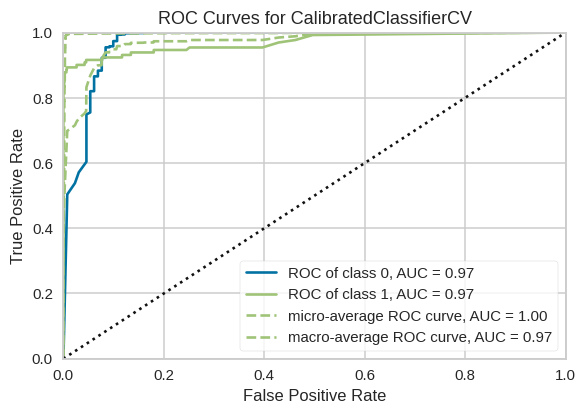

In [32]:
plot_model(calibrated_et, plot = 'auc', scale = 1.5)

### 7.2 Discrimination Threshold

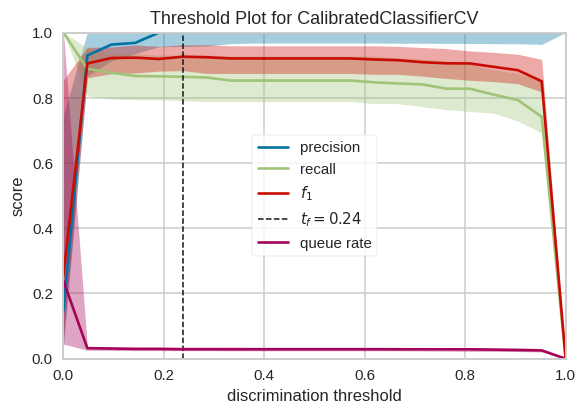

In [33]:
plot_model(calibrated_et, plot = 'threshold', scale = 1.5)

### 7.3 Precision Recall Curve

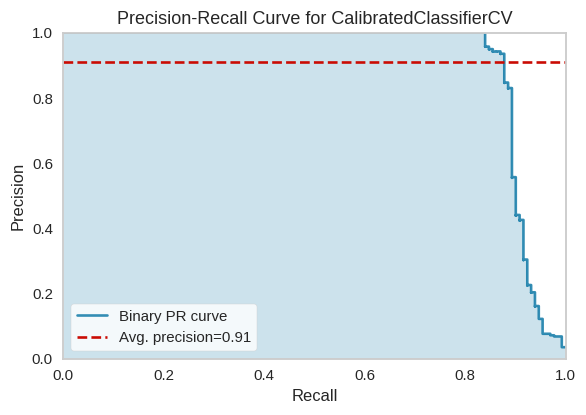

In [34]:
plot_model(calibrated_et, plot = 'pr', scale = 1.5)

### 7.4 Confusion matrix

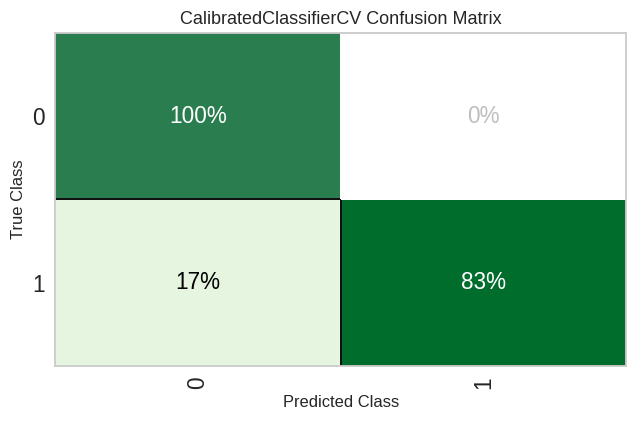

In [35]:
plot_model(
    calibrated_et, plot = 'confusion_matrix', plot_kwargs = {'percent' : True},    
    scale = 1.5
)

### 7.5 Class Prediction Error

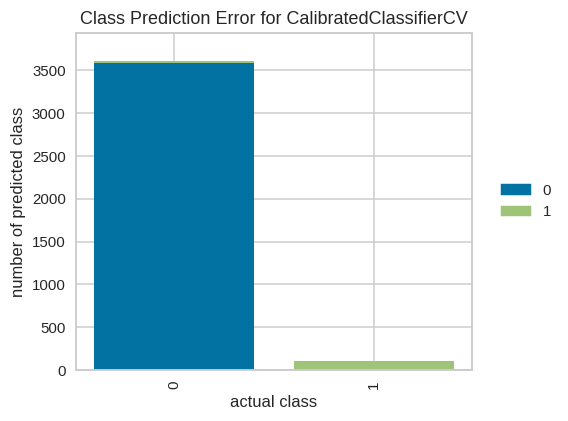

In [36]:
plot_model(calibrated_et, plot = 'error', scale = 1.5)

### 7.6 Classification Report

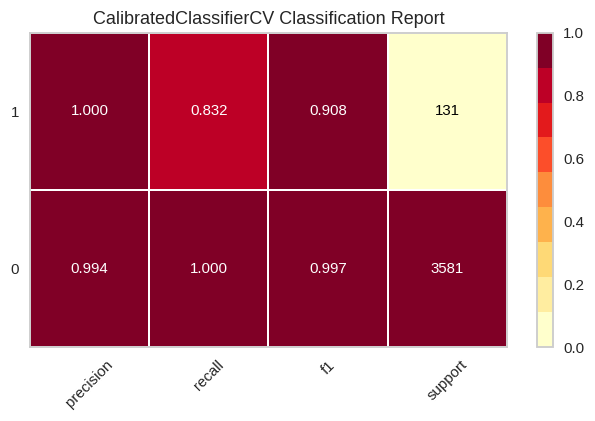

In [37]:
plot_model(calibrated_et, plot = 'class_report', scale = 1.5)

### 7.7 Decision Boundary

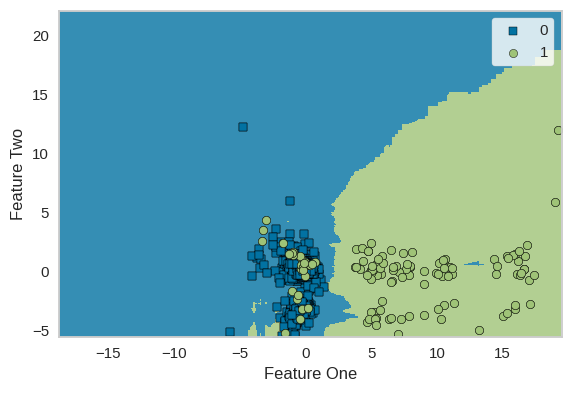

In [38]:
plot_model(calibrated_et, plot = 'boundary', scale = 1.5)

### 7.8 Learning Curve

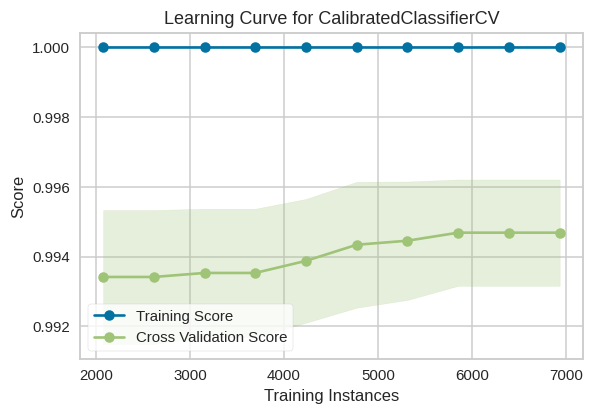

In [39]:
plot_model(calibrated_et, plot = 'learning', scale = 1.5)

### 7.9 Manifold Learning

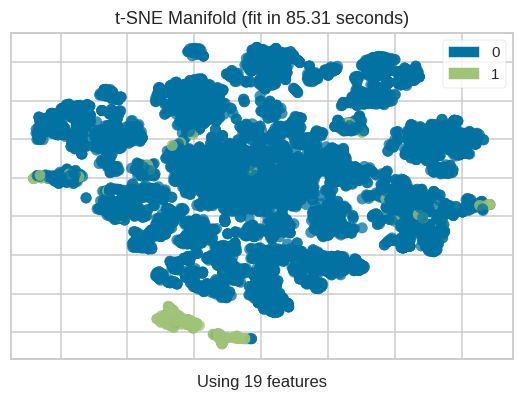

In [40]:
plot_model(calibrated_et, plot = 'manifold', scale = 1.5)

### 7.10 Calibration Curve

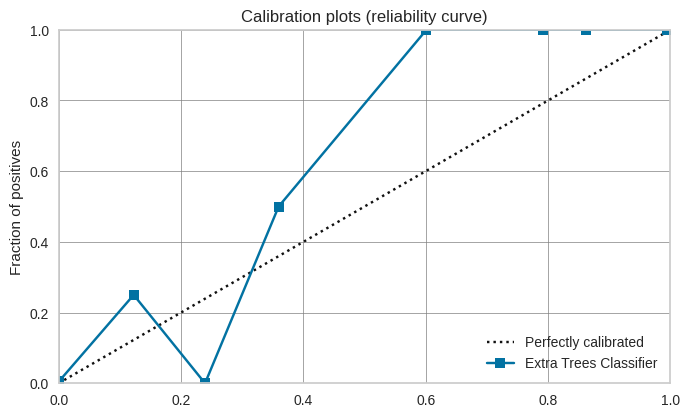

In [41]:
plot_model(calibrated_et, plot = 'calibration')

### 7.11 Validation Curve

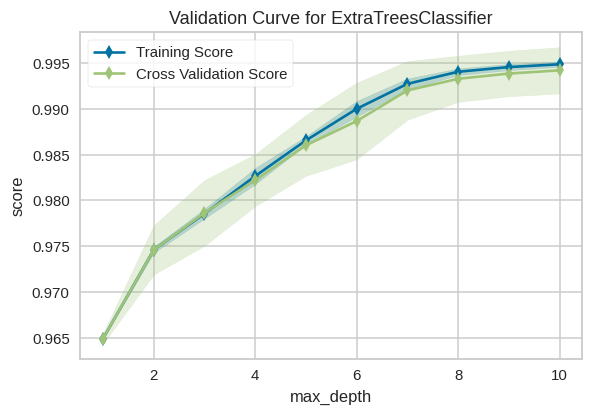

In [42]:
plot_model(top3[0], plot = 'vc', scale = 1.5)

### 7.12 Dimension Learning

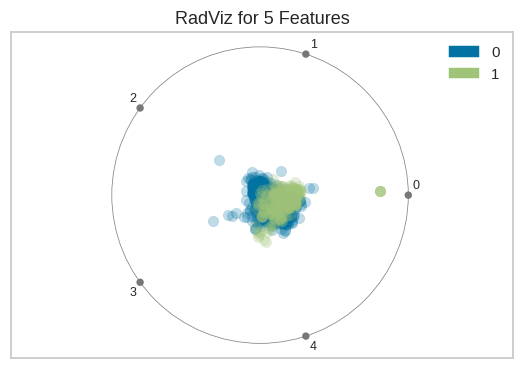

In [43]:
plot_model(calibrated_et, plot = 'dimension', scale = 1.5)

### 7.13 Feature Importance

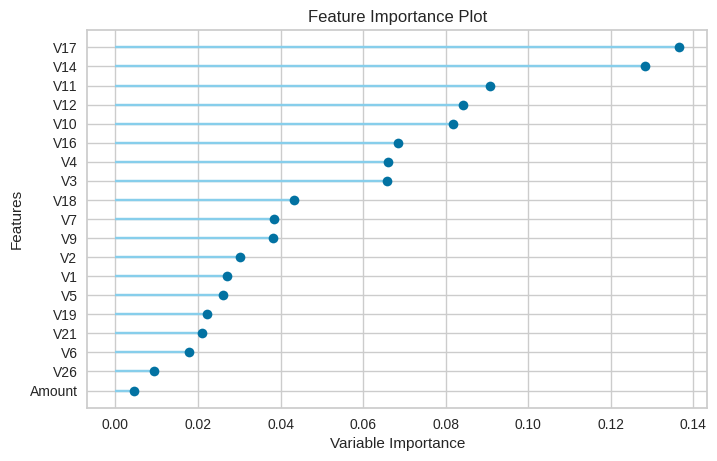

In [44]:
plot_model(top3[0], plot = 'feature_all')

### 7.14 Lift Curve

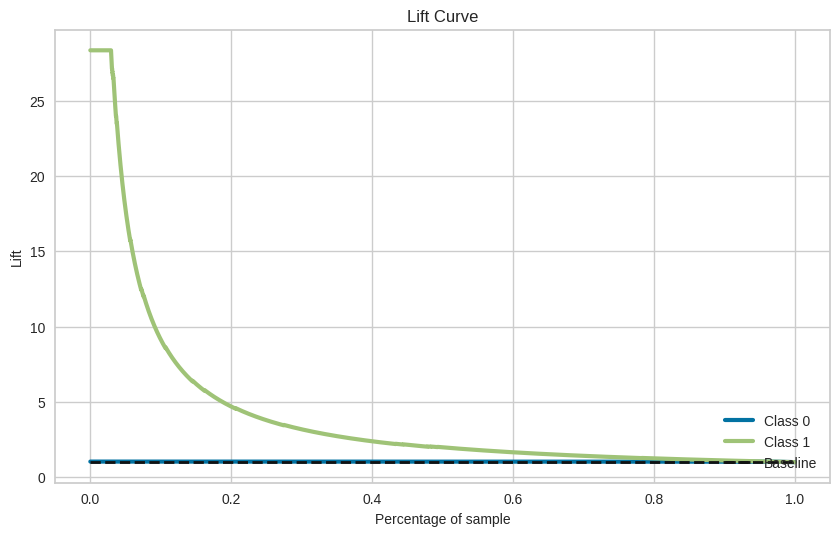

In [45]:
plot_model(calibrated_et, plot = 'lift')

### 7.15 Gain Curve

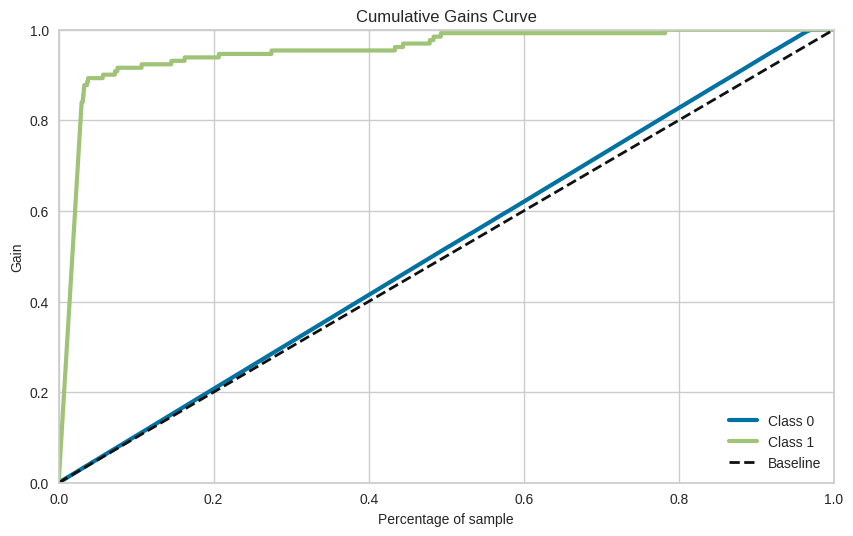

In [46]:
plot_model(calibrated_et, plot = 'gain')

### 7.16 KS Statistic Plot

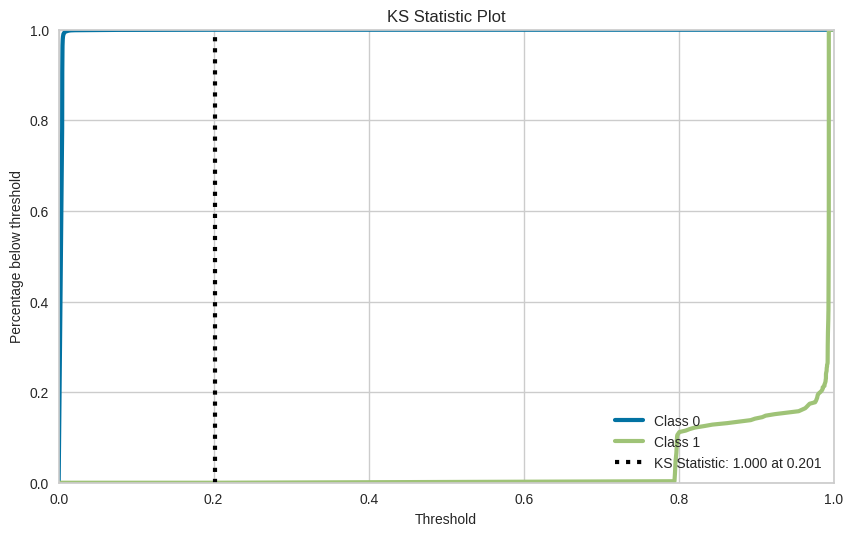

In [47]:
plot_model(calibrated_et, plot = 'ks')

## 8. Interpret model

### 8.1 SHAP (Shapley Additive exPlanations)

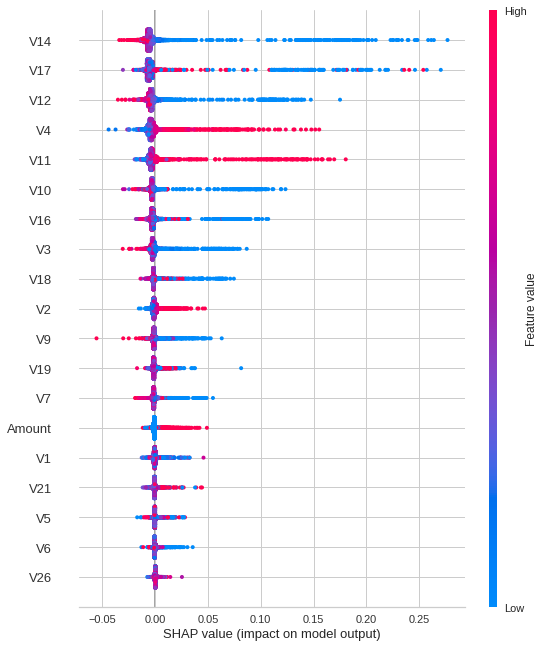

In [48]:
interpret_model(top3[0])

### 8.2 Morris Sensitivity Analysis

In [49]:
interpret_model(top3[0], plot = 'msa')

### 8.3 Permutation Feature Importance

In [50]:
interpret_model(top3[0], plot = 'pfi')

19it [00:02,  8.44it/s]


## 9. Save / load model

In [51]:
save_model(calibrated_et, 'et')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['V1', 'V2', 'V3', 'V4', 'V5', 'V6',
                                              'V7', 'V9', 'V10', 'V11', 'V12',
                                              'V14', 'V16', 'V17', 'V18', 'V19',
                                              'V21', 'V26', 'Amount'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose=0))),
                 ('cate...
                                             

In [52]:
et = load_model('et')
pprint(et)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['V1', 'V2', 'V3', 'V4', 'V5', 'V6',
                                             'V7', 'V9', 'V10', 'V11', 'V12',
                                             'V14', 'V16', 'V17', 'V18', 'V19',
                                             'V21', 'V26', 'Amount'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose=0))),
                ('cate...
     

## 10. Predictions

In [53]:
predict_model(et, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9994,0.9805,0.7544,0.7414,0.7478,0.7475,0.7475


,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,...,V16,V17,V18,V19,V21,V26,Amount,Class,prediction_label,prediction_score
0,-0.454526,-0.253940,1.972940,0.685468,-0.349573,0.520694,-0.934842,0.627675,-0.725171,-1.591153,...,-0.216232,0.452649,0.852996,0.594724,0.803651,-0.291398,-0.0,0,0,0.9952
1,-0.599680,-1.346997,1.217532,0.021021,2.378058,-0.961923,-1.006598,0.191864,-0.508452,0.261089,...,-0.248160,-0.193361,0.347335,1.069662,-0.313775,-1.057108,-0.0,0,0,0.9955
2,0.005718,0.170602,-0.393073,-0.809868,1.541755,-0.225555,1.590179,0.040873,-0.346784,-0.005013,...,-0.336449,-0.837211,0.221002,-0.082169,0.473519,-1.039064,-0.0,0,0,0.9955
3,-0.121787,0.876834,-0.553632,0.319498,1.108528,-0.405284,1.171869,-0.512126,0.814254,0.117332,...,-0.506983,-0.412557,0.581138,0.914814,0.719120,-0.939208,-0.0,0,0,0.9955
4,0.172281,0.497067,-0.540624,-0.876628,1.331569,-0.401764,1.397237,-0.324519,-0.312677,0.112132,...,-0.212506,-0.686904,0.442063,0.383441,0.557153,0.347064,-0.0,0,0,0.9955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45609,-1.727325,7.123216,-1.953804,-1.561180,-2.944288,-2.404923,-3.431835,1.649771,5.941045,-1.371919,...,1.331396,3.373368,0.578356,-0.744855,0.558800,0.501526,-0.0,0,0,0.9948
45610,-0.221948,-0.096778,1.329772,-0.526640,0.795465,0.941567,0.038450,0.530209,-0.760124,-0.128460,...,-0.623072,0.038959,-0.949807,-1.721369,0.560553,-0.633678,-0.0,0,0,0.9954
45611,1.185251,-0.269995,-1.043082,-0.401852,2.438479,2.041229,-0.243297,0.408696,-0.352238,0.216177,...,0.095093,0.454711,0.447844,-0.628661,0.602155,-0.048686,-0.0,0,0,0.9955
45612,-0.065678,0.316352,0.259861,0.320605,-0.171533,0.659940,-0.564419,0.376793,-0.277283,-1.726808,...,-0.549700,0.725884,1.329102,2.732066,0.679394,0.922871,-0.0,0,0,0.9954
